In [2]:
%matplotlib notebook
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [3]:
import numpy as np
import pandas as pd

In [4]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [5]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [6]:
engine = create_engine("sqlite:///hawaii.sqlite")


In [7]:
# reflect an existing database into a new model
Basehawaii = automap_base()
# reflect the tables
Basehawaii.prepare(engine, reflect=True)

In [8]:
# We can view all of the classes that automap found
Basehawaii.classes.keys()


['measurement', 'station']

In [9]:
# Save references to each table
Measurement = Basehawaii.classes.measurement
Station = Basehawaii.classes.station

In [10]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

('2017-08-23',)
2016-08-23


<IPython.core.display.Javascript object>


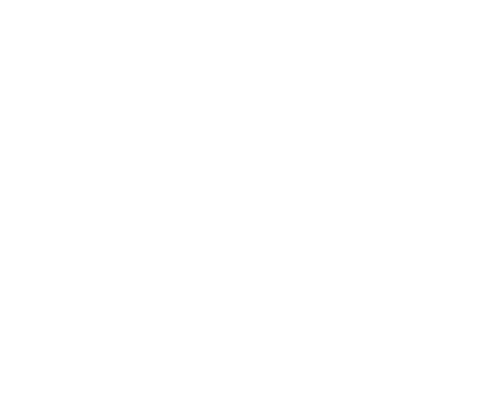

<IPython.core.display.Javascript object>


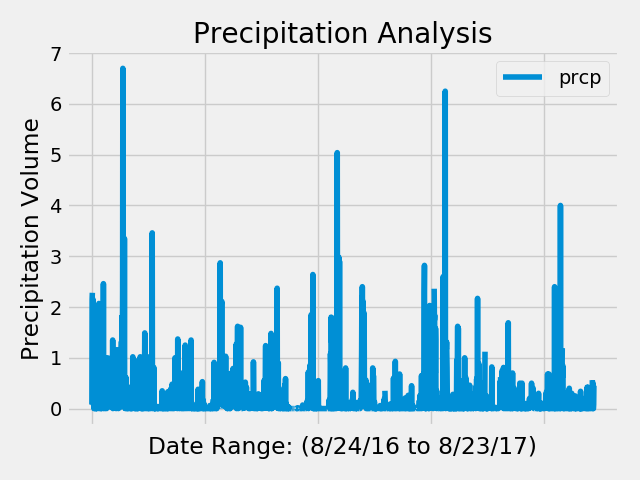

In [11]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
last_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
print(last_date)

# Calculate the date 1 year ago from the last data point in the database
one_year_ago = dt.date(2017,8,23) - dt.timedelta(days=365)
print(one_year_ago)

# Perform a query to retrieve the data and precipitation scores
pscores = session.query(Measurement.date,Measurement.prcp).\
    filter(Measurement.date > one_year_ago).\
    order_by(Measurement.date).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
pscores_df = pd.DataFrame(pscores, columns=['date','prcp'])
pscores_df.set_index('date').head()

# Sort the dataframe by date
pscores_df.sort_values(by='date', ascending=False)

# Use Pandas Plotting with Matplotlib to plot the data

figure1 = plt.figure(figsize=(5,4))
pscores_df.plot('date','prcp')
plt.grid(True)
plt.xlabel("Date Range: (8/24/16 to 8/23/17)")
plt.ylabel("Precipitation Volume")
plt.title("Precipitation Analysis")
plt.legend()
plt.tight_layout()
plt.show()
plt.close(figure1)


![precipitation](Images/precipitation.png)

In [12]:
# Use Pandas to calcualte the summary statistics for the precipitation data
pscores_df.describe()

,prcp
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


![describe](Images/describe.png)

In [13]:
# Design a query to show how many stations are available in this dataset?
num_stations = session.query(Measurement).group_by(Measurement.station).count()
print(num_stations)

9


In [15]:
# What are the most active stations? (i.e. what stations have the most rows)?
w_observations = session.query(Measurement.station, func.count(Measurement.tobs)).group_by(Measurement.station).\
               order_by(func.count(Measurement.tobs).desc()).all()

popstation = w_observations[0][0]    
popstation

# List the stations and the counts in descending order.
print("-----------------------------------------------------------------")
print("La estación con más registros es",popstation,"y contiene",w_observations[0][1],"weather observations.")



-----------------------------------------------------------------
La estación con más registros es USC00519281 y contiene 2772 weather observations.


In [16]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
lowest_temp = session.query(func.min(Measurement.tobs)).all()
lowest_temp

highest_temp = session.query(func.max(Measurement.tobs)).all()
highest_temp

average_temperature = session.query(func.avg(Measurement.tobs)).all()
average_temperature

[(73.09795396419437)]

In [17]:
# Choose the station with the highest number of temperature observations.
tobs_df = pd.DataFrame(w_observations, columns=['Date','tobs'])

# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
tobs_df.head()


,Date,tobs
0,USC00519281,2772
1,USC00519397,2724
2,USC00513117,2709
3,USC00519523,2669
4,USC00516128,2612


<IPython.core.display.Javascript object>


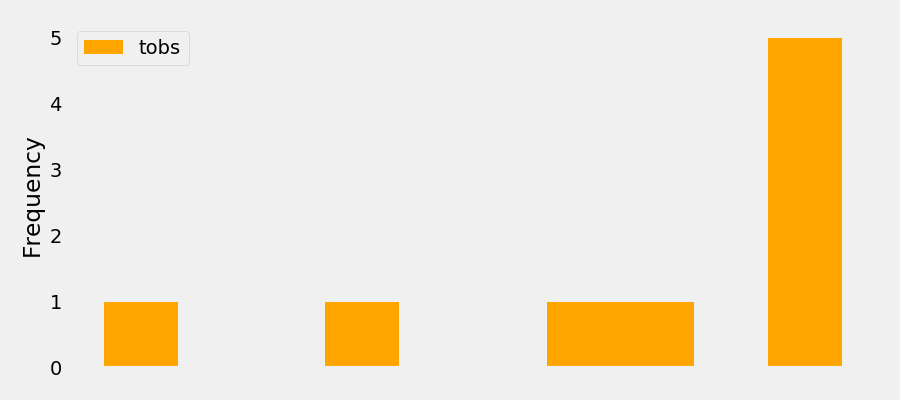

In [20]:
prcd_ax = tobs_df.plot('Date','tobs', kind='hist', color="orange",figsize=(9,4), alpha=0.9999)
prcd_ax.get_xaxis().set_visible(False)
plt.xticks(rotation=45)
plt.xlabel("Date")
plt.grid(which='major')
# plt.savefig("Output/tobs_histogram.png")
plt.tight_layout()
plt.show()

![precipitation](Images/station-histogram.png)

In [24]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [26]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
temp_mam = calc_temps('2011-08-23','2012-08-23')
temp_info = temp_mam[0]
temp_info

(56.0, 72.34107076001497, 86.0)

<IPython.core.display.Javascript object>


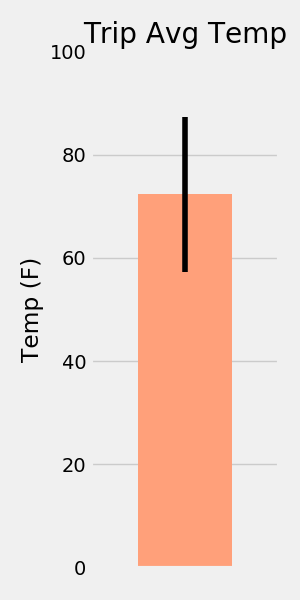

In [28]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

temp_min = temp_info[0]
temp_avg = temp_info[1]
temp_max = temp_info[2]
x=0
y_error_bar = round(temp_max - temp_min,0)
fig,ax= plt.subplots(figsize=(3,6))

plt.bar(x, temp_avg, width=.25, yerr=.5*(y_error_bar), alpha=.9999, color='lightsalmon')

plt.ylabel('Temp (F)')
plt.title('Trip Avg Temp')
plt.ylim(0, 100)
plt.xlim(-.25,.25)
ax.set_xticklabels([])
plt.grid(False, axis="x")

plt.tight_layout()
plt.show()


In [30]:
# Calculate the rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

rain_station = session.query(Measurement.station, Station.name, Station.latitude, Station.longitude,
Station.elevation, func.sum(Measurement.prcp)).\
            filter(Measurement.date.between('2010-08-23','2011-08-23')).\
            group_by(Measurement.station).\
            join(Station, Measurement.station==Station.station).\
            order_by(func.sum(Measurement.prcp).desc()).all()

print(rain_station)

[('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4, 146.4), ('USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9, 91.88000000000007), ('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6, 71.63000000000008), ('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5, 45.54), ('USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0, 45.27000000000004), ('USC00518838', 'UPPER WAHIAWA 874.3, HI US', 21.4992, -158.0111, 306.6, 37.82000000000002), ('USC00511918', 'HONOLULU OBSERVATORY 702.2, HI US', 21.3152, -157.9992, 0.9, 30.41000000000004), ('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 22.720000000000017), ('USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9, 12.319999999999999)]


## Optional Challenge Assignment

In [20]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [21]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


[(62.0, 69.15384615384616, 77.0),
 (60.0, 69.39622641509433, 77.0),
 (62.0, 68.9090909090909, 77.0),
 (58.0, 70.0, 76.0),
 (56.0, 67.96428571428571, 76.0),
 (61.0, 68.96491228070175, 76.0),
 (57.0, 68.54385964912281, 76.0)]

In [22]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


,tmin,tavg,tmax
date,,,
2018-01-01,62.0,69.153846,77.0
2018-01-02,60.0,69.396226,77.0
2018-01-03,62.0,68.909091,77.0
2018-01-04,58.0,70.000000,76.0
2018-01-05,56.0,67.964286,76.0


<IPython.core.display.Javascript object>


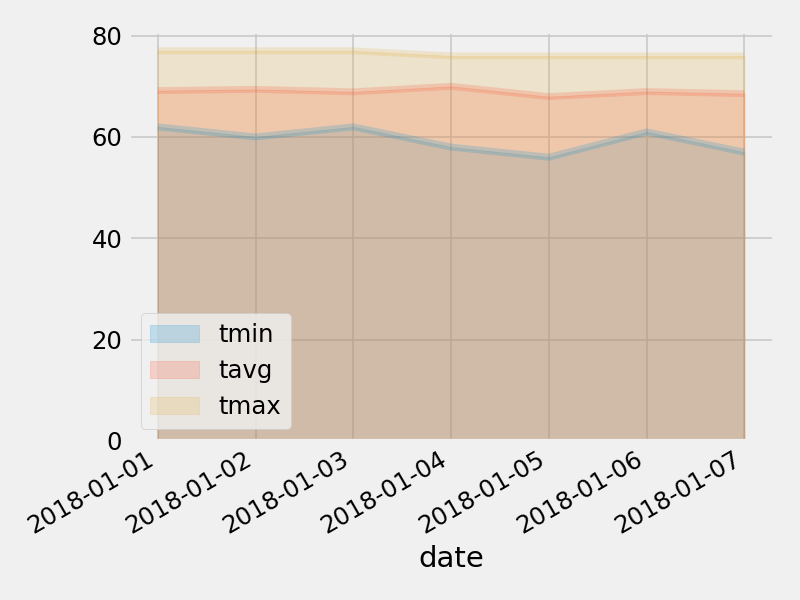

In [23]:
# Plot the daily normals as an area plot with `stacked=False`
